In [ ]:
##!/usr/bin/env python
"""plot_skill.py

This script compares the heatwave diagnostics of CMIP6 to Berkeley Earth

Using the Excess Heat Factor 
Baseline Period: 1950-2014, 90th Percentile Threshold

Author: Annette L Hirsch @ CLEX, UNSW. Sydney (Australia)
email: a.hirsch@unsw.edu.au
Created: Wed Nov 11 10:54:39 AEDT 2020

"""

### Load Python Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#from __future__ import division
import numpy as np
import netCDF4 as nc
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import common_functions as cf
import cartopy.crs as ccrs
import xesmf as xe
from scipy import stats
from scipy import signal
import math
import regionmask

### Updated IPCC regions

This is a python package containing the new regions: import regionmask

Iturbide, M., Guti�errez, J.M., Alves, L.M., Bedia, J., Cimadevilla, E., Cofi~no, A.S., Cerezo-Mota, R., Di Luca, A., Faria, S.H., Gorodetskaya, I., Hauser, M., Herrera, S., Hewitt, H.T., Hennessy, K.J., Jones, R.G., Krakovska, S., Manzanas, R., Marínez-Castro, D., Narisma, G.T., Nurhati, I.S., Pinto, I., Seneviratne, S.I., van den Hurk, B., Vera, C.S., 2020. An update of IPCC climate reference regions for subcontinental analysis of climate model data: definition and aggregated datasets. Earth Syst. Sci. Data Discuss. https://doi.org/10.5194/essd-2019-258

Git repo with the new regions: https://github.com/SantanderMetGroup/ATLAS/tree/master/reference-regions

In [3]:
rlabels = ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS',
                  'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA', 'NEU', 'WCE', 'EEU', 'MED',
                  'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG', 'RAR', 'WSB',
                  'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA', 'NAU',
                  'CAU', 'EAU', 'SAU', 'NZ', 'EAN', 'WAN']
nreg = len(rlabels)

ar6_land = regionmask.defined_regions.ar6.land

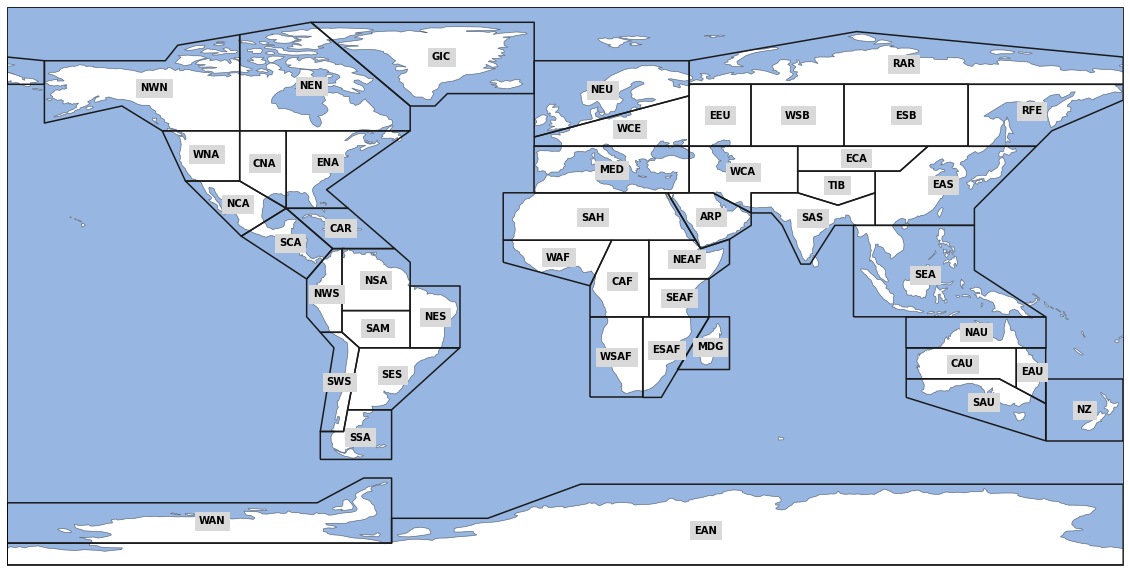

In [4]:
projection = ccrs.PlateCarree(central_longitude=0)
plt.rcParams['savefig.dpi']=500
plt.rcParams["font.weight"] = "bold"
fig, ax = plt.subplots(1,1,figsize=(20,30), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
ax = ar6_land.plot(proj=projection, label="abbrev", add_ocean=True)
plt.savefig('ar6_climate_reference_regions.png')

### Berkeley Earth

This data has nlat = 180, nlon = 360 so it is 1deg data

In [5]:
berkdir = '/g/data/w97/azh561/cmip_heatwave/BerkleyEarth/'

# Define the summer statistics of interest / variable names in the netcdf files
var = ['HWA','HWM','HWN','HWF','HWD']
nvar = len(var)
omn = [0,0,0,10,0] # minima for the observed mean
omx = [30,10,5,20,10] # maxima for the observed mean
varlim = [50,20,10,20,10] # bias limits

# Define the filename convention:
bprefix = 'EHF_'
bendfix = '_summer_BerkleyEarth_1950-2014.nc'

# for the cumulative heat
ehifile = 'BerkleyEarth_HW_daily_EHI_value_1950_2017_bp_1950_2014.nc'
spellfile = 'BerkleyEarth_HW_daily_EHF_1950_2017_bp_1950_2014.nc'

### CMIP6 data

Note that in this instance we start with the first ensemble member 'r1i1p1f1' for all models

They are all on different resolutions! So will require regridding to plot and evaluate:

    - finest resolution: nlat = 256, nlon = 512 -> 0.7 deg x 0.7 deg
    - coarsest resolution: nlat = 96, nlon = 144 -> 1.875 deg x 2.5 deg

In [6]:
cmip6dir = '/g/data/w97/azh561/cmip_heatwave/cmip6_ehf/'

# Define the models
models = ['ACCESS-CM2','AWI-CM-1-1-MR','AWI-ESM-1-1-LR','BCC-CSM2-MR','BCC-ESM1','CanESM5','CMCC-CM2-SR5',
'EC-Earth3-AerChem','EC-Earth3','EC-Earth3-Veg','EC-Earth3-Veg-LR','FGOALS-f3-L','FGOALS-g3','GFDL-CM4',
'GFDL-ESM4','GISS-E2-1-G','INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MIROC6',
'MPI-ESM-1-2-HAM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorCPM1','NorESM2-LM','NorESM2-MM','TaiESM1']

nmod = len(models)

# Define the summer statistics of interest / variable names in the netcdf files
modvar = ['HWA_EHF','HWM_EHF','HWN_EHF','HWF_EHF','HWD_EHF']

# Define the filename convention:
mprefix = 'EHF_heatwaves_'
mendfix = '_historical_r1i1p1f1_yearly_summer.nc'

# The EHI files
ehipfix = 'EHI_heatwaves_'
ehfpfix = 'EHF_heatwaves_'
ehiefix = '_historical_r1i1p1f1_daily.nc'


### Functions Used in this notebook

In [7]:
def plot_contour(lat1d,lon1d,odata,data,mlabel,omn,omx,mn,mx,figurename):

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    from matplotlib import colors
    from matplotlib import cm
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    import cartopy.crs as ccrs
    from string import ascii_lowercase
    
    # Figure formatting
    plt.rcParams['savefig.dpi']=300
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    
    # Set up projection
    plotcrs = ccrs.PlateCarree(central_longitude=0)
    lon2d, lat2d = np.meshgrid(lon1d, lat1d)
    
    nmod = data.shape[0]

    nrow = 8
    ncol = 4
    r = [0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7]
    c = [1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol, figsize=((4*ncol)+2,2*nrow), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

    # Define the levels for the contour lines
    nbins=20
    cmap = plt.get_cmap('seismic')
    ocmap = plt.get_cmap('seismic') #plt.get_cmap('hot_r')
    ocmap.set_bad('w')
    olevels = MaxNLocator(nbins=10).tick_values(omn,omx)
    onorm = BoundaryNorm(olevels, ncolors=ocmap.N, clip=True)
    
    cmap.set_bad('w')
    levels = MaxNLocator(nbins=nbins).tick_values(mn,mx)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    # Add the observed value to the plot
    co = ax[0,0].contourf(lon2d,lat2d,odata,vmin=omn,vmax=omx,cmap=ocmap, levels=olevels, norm=onorm, extend='both',transform=ccrs.PlateCarree())
    ax[0,0].coastlines()
    ax[0,0].text(0.016,0.035,'Berkeley Earth',horizontalalignment='left',verticalalignment='bottom',bbox=dict(boxstyle='round', facecolor='white', alpha=0.75),transform = ax[0,0].transAxes,fontweight='bold', fontsize=14)
    caxo = fig.add_axes([-0.0175, 0.885, 0.02, 0.1]) # [left, bottom, width, height]
    plt.colorbar(co, caxo)   
    caxo.yaxis.tick_left()

    # Loop through the models
    for mm in range(nmod):        
        cm = ax[r[mm],c[mm]].contourf(lon2d,lat2d,data[mm,:,:],vmin=mn,vmax=mx,cmap=cmap, levels=levels, norm=norm, extend='both',transform=ccrs.PlateCarree())
        ax[r[mm],c[mm]].coastlines()
        ax[r[mm],c[mm]].text(0.016,0.035,mlabel[mm],horizontalalignment='left',verticalalignment='bottom',bbox=dict(boxstyle='round', facecolor='white', alpha=0.75),transform = ax[r[mm],c[mm]].transAxes,fontweight='bold', fontsize=14)
   
    # Colorbars
    cax = fig.add_axes([1.0, 0.025, 0.02, 0.95]) # [left, bottom, width, height]
    plt.colorbar(cm, cax)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    #plt.savefig(figurename, bbox_inches='tight')
    #plt.close(fig)


### Process and Plot Global Contour Map

The sequence is read in the data, regrid to common grid, calculate diagnostic and then plot

Calculating and plotting HWA


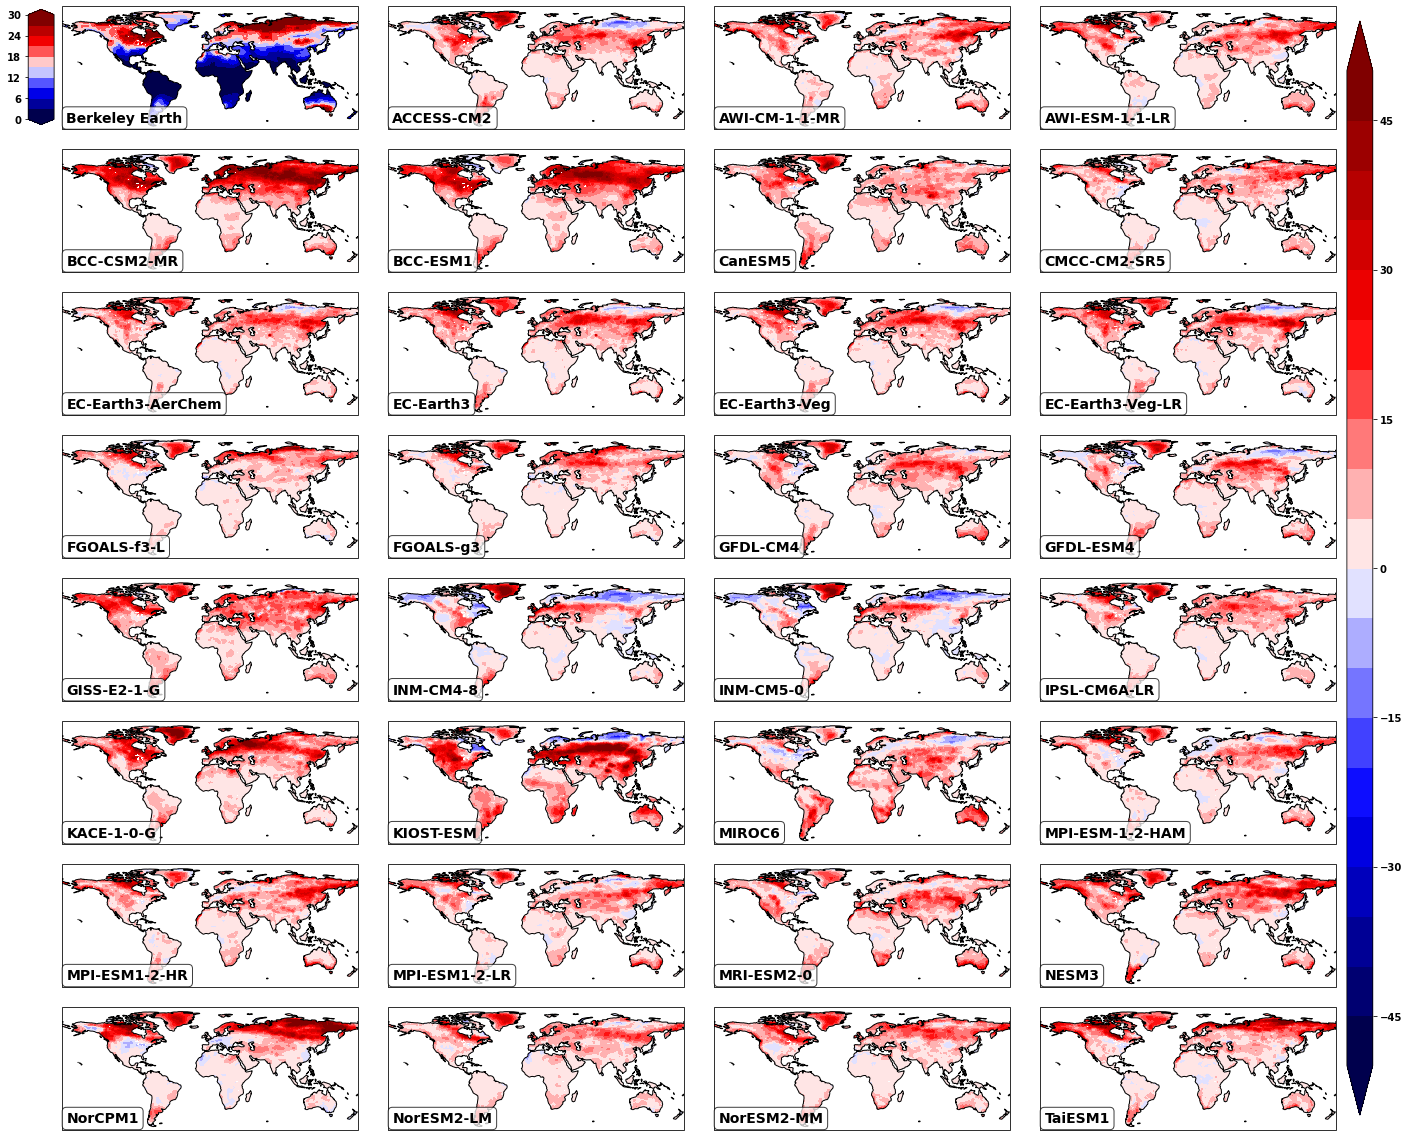

In [8]:
nyrs = 65
for eind in [0]: #range(nvar):
    
    print('Calculating and plotting %s' %(var[eind]))
    
    # Read in the Berkeley Earth data - decode times necessary as HWF and HWD in units of days
    berk = xr.open_dataset('%s%s%s%s' %(berkdir,bprefix,var[eind],bendfix),decode_times=False)
    berkma = np.ma.masked_array(berk[var[eind]].values,berk[var[eind]].values<=0).filled(np.nan)
 
    # Define the common grid for the models to regrid too!
    ds_out = xr.Dataset({'lat': (['lat'], berk['latitude'].values),
             'lon': (['lon'], berk['longitude'].values),
            })

    # Define the land-sea mask (region = 0, elsewhere is nan)
    land_110 = regionmask.defined_regions.natural_earth.land_110
    land_mask = land_110.mask(ds_out)
    mask2d = ar6_land.mask(ds_out) * land_mask.squeeze(drop=True)

    # Calculate the observed mean
    berkmean = np.nanmean(berkma,axis=0)
        
    # Now loop through the models and regrid
    moddata = np.empty((nmod,nyrs,len(berk['latitude'].values), len(berk['longitude'].values)),dtype=np.float64)
    for mind in range(nmod):
        dm = xr.open_dataset('%s%s%s%s' %(cmip6dir,mprefix,models[mind],mendfix),decode_times=False)
        # If longitudes are 0 to 360 need to shift to -180 to 180
        # https://stackoverflow.com/questions/53345442/about-changing-longitude-array-from-0-360-to-180-to-180-with-python-xarray
        if np.nanmax(dm['lon']) > 200.:
            lon_name = 'lon'
            dm['_longitude_adjusted'] = xr.where(dm[lon_name] > 180,dm[lon_name] - 360,dm[lon_name])
            # reassign the new coords to as the main lon coords and sort DataArray using new coordinate values
            dm = (
                dm
                .swap_dims({lon_name: '_longitude_adjusted'})
                .sel(**{'_longitude_adjusted': sorted(dm._longitude_adjusted)})
                .drop(lon_name))
            dm = dm.rename({'_longitude_adjusted': lon_name})
            
        datavalue = dm[modvar[eind]]
        regridder = xe.Regridder(dm, ds_out, 'bilinear')
        moddata[mind,:,:,:] = regridder(datavalue)
        del dm, datavalue,regridder

   # Mask the missing values as these have not been set to nan in the files
    modma = np.ma.masked_array(moddata,moddata<=0).filled(np.nan)
            
    # Calculate the bias
    bias = np.empty((nmod,len(berk['latitude'].values), len(berk['longitude'].values)),dtype=np.float64)
    for mind in range(nmod): 
        bias[mind,:,:] = np.nanmean(modma[mind,:,:,:],axis=0) - np.nanmean(berkma,axis=0)
                
    # Plot the bias
    plot_contour(berk['latitude'].values[30:],berk['longitude'].values,berkmean[30:,:],bias[:,30:,:],models,omn[eind],omx[eind],-varlim[eind],varlim[eind],'contour_bias_%s.png' %(var[eind]))

    del berk,berkma,berkmean
    del moddata,modma
    del bias
    